
# Ungraded Lab: Convolutional Autoencoders

In this lab, you will use convolution layers to build your autoencoder. This usually leads to better results than dense networks and you will see it in action with the Fashion MNIST dataset.

https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/4-Generative-deeplearning-with-tensorflow/week-2/C4_W2_Lab_4_FashionMNIST_CNNAutoEncoder.ipynb

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Model


# Prepare the Dataset

As before, you will load the train and test sets from TFDS. Notice that we don't flatten the image this time. That's because we will be using convolutional layers later that can deal with 2D images.


In [3]:

def map_image(image, label):
    '''Normalizes the image. Returns image as input and label.'''
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0

    return image, image

In [6]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split='test')
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

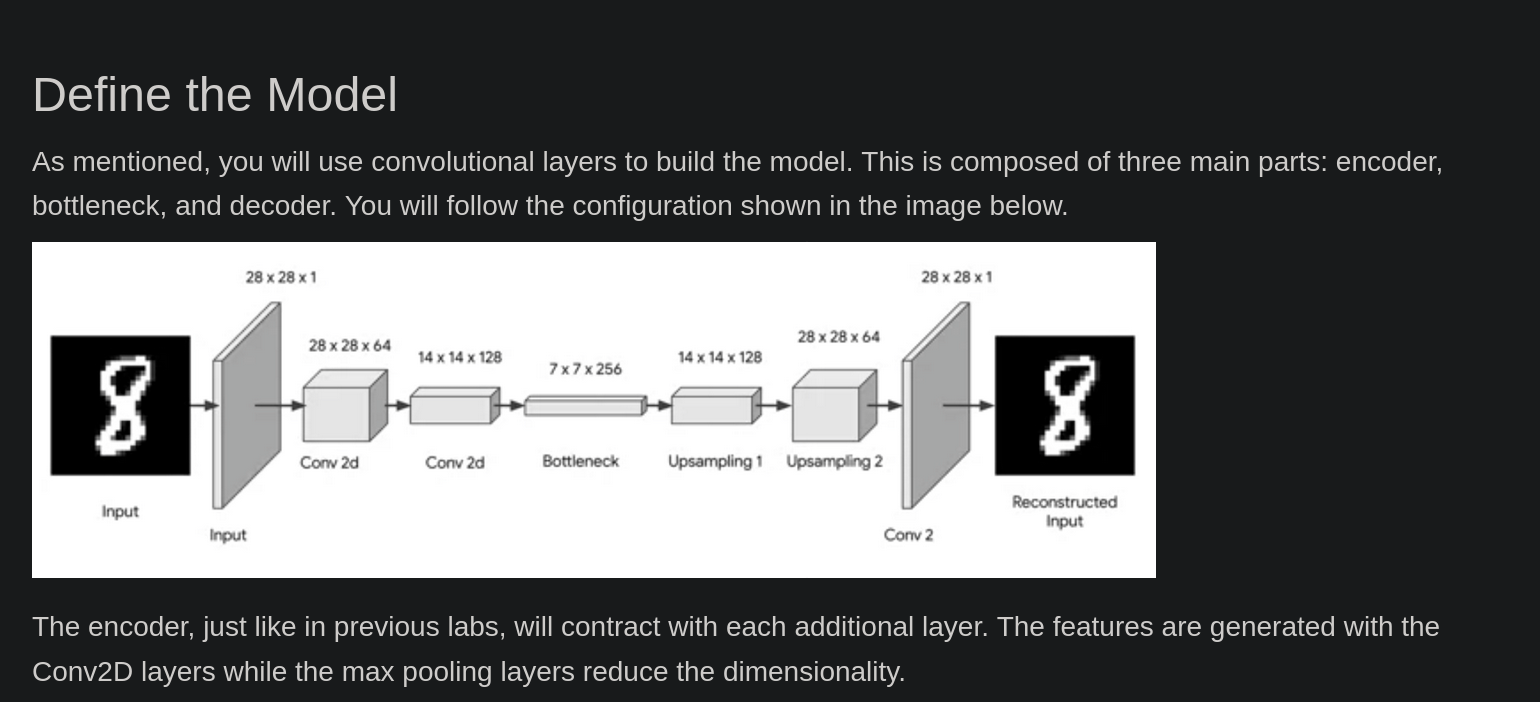

In [7]:
def encoder(inputs):
    '''defines the encoder with two conve2d and maxpooling layers'''
    conv1 = Conv2D(filters=64, kernel_size=(3,3),
                                   activation='relu', padding='same')(inputs)
    max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(filters=128, kernel_size=(3,3),
                            activation='relu', padding='same')(max_pool1)
    max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
    
    return max_pool2



A bottleneck layer is used to get more features but without further reducing the dimension afterwards. Another layer is inserted here for visualizing the encoder output.


In [8]:

def bottle_neck(inputs):
    bottleneck = Conv2D(filters=256, kernel_size=(3,3), activation='relu',
                        padding="same")(inputs)
    
    # a non-essintial layer that we use to visualize. this doesn't go to the 
    #autoencoder - this layer doesn't impact the autoencoder
    encoder_visualization = Conv2D(filters=1, kernel_size=(3,3),
                                   activation='sigmoid', padding="same")(bottleneck)
    
    return bottleneck, encoder_visualization

In [11]:
def decoder(inputs):
    '''defines the decoder path to upsample back to the original image size'''
    k = (3,3)
    a = 'relu'
    a2 = 'sigmoid'
    p = 'same'
    u = (2,2)
    
    conv1 = Conv2D(filters=128, kernel_size=k, activation=a, padding=p)(inputs)
    upsample1 = UpSampling2D(size=u)(conv1)
    
    conv2 = Conv2D(filters=64, kernel_size=k, activation=a, padding=p)(upsample1)
    upsample2 = UpSampling2D(size=u)(conv2)
    
    # this will reconstruct the image giving us a 28x28x1 output
    conv3 = Conv2D(filters=1, kernel_size=k, activation=a2, padding=p)(upsample2)
    
    return conv3

In [12]:
def convolutional_auto_encoder():
    inputs = tf.keras.layers.Input(shape=(28,28,1))
    encoder_output = encoder(inputs)
    bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
    decoder_output = decoder(bottleneck_output)
    
    model = Model(inputs=inputs, outputs = decoder_output)
    encoder_model = Model(inputs=inputs, outputs=encoder_visualization)
    return model, encoder_model

In [13]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

TypeError: Inputs to a layer should be tensors. Got: <keras.layers.convolutional.Conv2D object at 0x7f803405ac50>